In [ ]:
sentences_to_read = 25000

In [ ]:
# Loading train.combined as source_sent and summaries.txt as target_sent
source_sent = []
target_sent = []

test_source_sent = []
test_target_sent = []


with open('WeatherGov/train/train.combined', 'r') as f:
    for l_i, line in enumerate(f):
        source_sent.append(line)
        if len(source_sent)>=sentences_to_read:
            break
        
            
with open('WeatherGov/train/summaries.txt', 'r') as f:
    for l_i, line in enumerate(f):
        target_sent.append(line)
        if len(target_sent)>=sentences_to_read:
            break
        
            
assert len(source_sent)==len(target_sent),'Source: %d, Target: %d'%(len(source_sent),len(target_sent))

print('Sample translations (%d)'%len(source_sent))
for i in range(0,sentences_to_read,10000):
    print('(',i,') Table: ', source_sent[i])
    print('(',i,') Summary: ', target_sent[i])


Sample translations (25000)
( 0 ) Table:  temperature time 6-21 min 26 mean 43 max 53 windChill time 6-21 min 0 mean 22 max 46 windSpeed time 6-21 min 6 mean 8 max 10 mode-bucket-0-20-2 0-10 windDir time 6-21 mode SE gust time 6-21 min 0 mean 0 max 0 skyCover time 6-21 mode-bucket-0-100-4 50-75 skyCover time 6-9 mode-bucket-0-100-4 0-25 skyCover time 6-13 mode-bucket-0-100-4 25-50 skyCover time 9-21 mode-bucket-0-100-4 50-75 skyCover time 13-21 mode-bucket-0-100-4 50-75 precipPotential time 6-21 min 0 mean 2 max 12

( 0 ) Summary:  Mostly sunny , with a high near 53 . Southeast wind between 7 and 9 mph . 

( 10000 ) Table:  temperature time 6-21 min 29 mean 31 max 35 windChill time 6-21 min 16 mean 21 max 25 windSpeed time 6-21 min 8 mean 15 max 21 mode-bucket-0-20-2 10-20 windDir time 6-21 mode WNW gust time 6-21 min 0 mean 12 max 29 skyCover time 6-21 mode-bucket-0-100-4 50-75 skyCover time 6-9 mode-bucket-0-100-4 50-75 skyCover time 6-13 mode-bucket-0-100-4 50-75 skyCover time 9-21 

In [ ]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [ ]:
data = pd.DataFrame()
data['cleaned_text']=source_sent
data['cleaned_summary']=target_sent

In [ ]:
data.head()

,cleaned_text,cleaned_summary
0,temperature time 6-21 min 26 mean 43 max 53 windChill time 6-21 min 0 mean 22 max 46 windSpeed time 6-21 min 6 mean 8 max 10 mode-bucket-0-20-2 0-10 windDir time 6-21 mode SE gust time 6-21 min 0 ...,"Mostly sunny , with a high near 53 . Southeast wind between 7 and 9 mph . \n"
1,temperature time 17-30 min 47 mean 50 max 58 windChill time 17-30 min 0 mean 30 max 49 windSpeed time 17-30 min 3 mean 5 max 9 mode-bucket-0-20-2 0-10 windDir time 17-30 mode E gust time 17-30 min...,"A 50 percent chance of showers . Cloudy , with a low around 47 . East wind around 5 mph . \n"
2,temperature time 17-30 min 51 mean 55 max 62 windChill time 17-30 min 0 mean 0 max 0 windSpeed time 17-30 min 2 mean 3 max 6 mode-bucket-0-20-2 0-10 windDir time 17-30 mode SSE gust time 17-30 min...,"Cloudy , with a low around 49 . Calm wind becoming south southeast around 5 mph . \n"
3,temperature time 17-30 min 26 mean 29 max 38 windChill time 17-30 min 26 mean 28 max 36 windSpeed time 17-30 min 0 mean 0 max 5 mode-bucket-0-20-2 0-10 windDir time 17-30 mode ESE gust time 17-30 ...,"Partly cloudy , with a low around 23 . Calm wind . \n"
4,temperature time 17-30 min 55 mean 60 max 69 windChill time 17-30 min 0 mean 0 max 0 windSpeed time 17-30 min 8 mean 9 max 14 mode-bucket-0-20-2 0-10 windDir time 17-30 mode SSW gust time 17-30 mi...,"Partly cloudy , with a low around 53 . South wind around 9 mph . \n"


In [ ]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

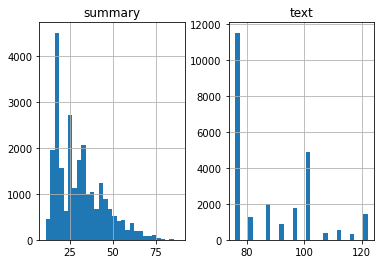

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [ ]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=60):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.96256


In [ ]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=120):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.94176


In [ ]:
max_text_len=120
max_summary_len=60

In [ ]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [ ]:
df.to_csv('cleaned_weather_data.csv')

In [ ]:
MAX_SEQUENCE_LENGTH = max_text_len
MAX_NUM_WORDS = 140
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.1

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 0.0
Total Coverage of rare words: 0.0


In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)



In [ ]:
#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [ ]:
x_voc

140

In [ ]:
x_val[10]

array([ 25,   1,   9,   8,  11,  72,  12,  87,  13, 103,  26,   1,   9,
         8,  11,   2,  12,  23,  13,  16,  27,   1,   9,   8,  11,  40,
        12,  33,  13,  23,   3,   6,   2,  19,  24,   2,  23,  28,   1,
         9,   8,   3, 100,  29,   1,   9,   8,  11,   2,  12,   2,  13,
         2,  14,   1,   9,   8,   3,   6,   2,   4,  10,   2,  17,  14,
         1,   9,   5,   3,   6,   2,   4,  10,   2,  17,  14,   1,   9,
        22,   3,   6,   2,   4,  10,   2,  17,  14,   1,   5,   8,   3,
         6,   2,   4,  10,   2,  17,  14,   1,  22,   8,   3,   6,   2,
         4,  10,   2,  17,  30,   1,   9,   8,  11,   2,  12,   2,  13,
         2,   0,   0], dtype=int32)

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=3

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 9.090909090909092
Total Coverage of rare words: 0.0070722033736321495


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [ ]:
y_tokenizer.word_counts['sostok'],len(y_tr)   

(20584, 20584)

In [ ]:
EMBEDDING_DIM = 100

In [ ]:
embeddings_index = {}
f = open( 'glove.6B.100d.txt?content=true')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index
word_index=x_tokenizer.word_index

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix_1 = np.zeros((len(target_word_index) + 1, EMBEDDING_DIM))
for word, i in target_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_1[i] = embedding_vector

In [ ]:
# from math import log
# from numpy import array
# from numpy import argmax
 
# # beam search
# def beam_search_decoder(data, k):
# 	sequences = [[list(), 0.0]]
# 	# walk over each step in sequence
# 	for row in data:
# 		all_candidates = list()
# 		# expand each current candidate
# 		for i in range(len(sequences)):
# 			seq, score = sequences[i]
# 			for j in range(len(row)):
# 				candidate = [seq + [j], score - log(row[j])]
# 				all_candidates.append(candidate)
# 		# order all candidates by score
# 		ordered = sorted(all_candidates, key=lambda tup:tup[1])
# 		# select k best
# 		sequences = ordered[:k]
# 	return sequences
 
# # define a sequence of 10 words over a vocab of 5 words
# data = [[0.1, 0.2, 0.3, 0.4, 0.5],
# 		[0.5, 0.4, 0.3, 0.2, 0.1],
# 		[0.1, 0.2, 0.3, 0.4, 0.5],
# 		[0.5, 0.4, 0.3, 0.2, 0.1],
# 		[0.1, 0.2, 0.3, 0.4, 0.5],
# 		[0.5, 0.4, 0.3, 0.2, 0.1],
# 		[0.1, 0.2, 0.3, 0.4, 0.5],
# 		[0.5, 0.4, 0.3, 0.2, 0.1],
# 		[0.1, 0.2, 0.3, 0.4, 0.5],
# 		[0.5, 0.4, 0.3, 0.2, 0.1]]
# data = array(data)
# # decode sequence
# result = beam_search_decoder(data, 3)
# # print result
# for seq in result:
# 	print(seq)

In [ ]:
# Bi-directional model
from keras import backend as K 
K.clear_session()

latent_dim = 128
embedding_dim=EMBEDDING_DIM

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)(encoder_inputs)

#encoder lstm 1
encoder_lstm = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.3,recurrent_dropout=0.2)
encoder_lstm1 = Bidirectional(encoder_lstm)
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm1(enc_emb)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])


# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(len(target_word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_1],
                            input_length=max_summary_len,
                            trainable=False)

dec_emb = dec_emb_layer(decoder_inputs)


decoder_lstm = LSTM(latent_dim* 2, return_sequences=True, return_state=True,dropout=0.3,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 120, 100)     14000       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 120, 256), ( 234496      embedding[0][0]                  
______________________________________________________________________________________________

In [ ]:
# from tensorflow import keras
# opt = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=10,callbacks=[es],batch_size=64, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/10
322/322 [==============================] - 322s 1s/step - loss: 0.8584 - accuracy: 0.8055 - val_loss: 0.3903 - val_accuracy: 0.8847
Epoch 2/10
322/322 [==============================] - 325s 1s/step - loss: 0.3505 - accuracy: 0.8942 - val_loss: 0.3009 - val_accuracy: 0.9063
Epoch 3/10
322/322 [==============================] - 322s 1s/step - loss: 0.2916 - accuracy: 0.9091 - val_loss: 0.2637 - val_accuracy: 0.9158
Epoch 4/10
322/322 [==============================] - 324s 1s/step - loss: 0.2546 - accuracy: 0.9191 - val_loss: 0.2286 - val_accuracy: 0.9261
Epoch 5/10
322/322 [==============================] - 322s 1000ms/step - loss: 0.2274 - accuracy: 0.9266 - val_loss: 0.2056 - val_accuracy: 0.9324
Epoch 6/10
322/322 [==============================] - 320s 993ms/step - loss: 0.2081 - accuracy: 0.9319 - val_loss: 0.1924 - val_accuracy: 0.9363
Epoch 7/10
322/322 [==============================] - 321s 996ms/step - loss: 0.1931 - accuracy: 0.9360 - val_loss: 0.1789 - val_accura

In [ ]:
model_save_name = 'weather_summary_bidirirectional.h5'
path = C"/content/My Drive/ Projects/{model_save_name}" 
# torch.save(model.state_dict(), path)
model.save(path)
print("Saved model to disk")

Saved model to disk


In [ ]:
# # save model and architecture to single file
# model.save("model.h5")
# print("Saved model to disk")

In [ ]:
from tensorflow.keras.models import load_model
 
# # load model
# model = load_model('model.h5')
# # summarize model.
# model.summary()

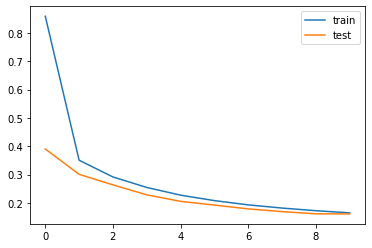

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim*2))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # e_h = e_h*0
    # e_c = e_c*0

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        # print(sampled_token)
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,5):
    print("Tabular data:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Tabular data: temperature time 17 30 min 67 mean 70 max 77 windchill time 17 30 min 0 mean 0 max 0 windspeed time 17 30 min 11 mean 12 max 16 mode bucket 0 20 2 10 20 winddir time 17 30 mode ese gust time 17 30 min 0 mean 3 max 21 skycover time 17 30 mode bucket 0 100 4 25 50 skycover time 17 21 mode bucket 0 100 4 25 50 skycover time 17 26 mode bucket 0 100 4 25 50 skycover time 21 30 mode bucket 0 100 4 25 50 skycover time 26 30 mode bucket 0 100 4 25 50 precippotential time 17 30 min 2 mean 4 max 5 
Original summary: partly cloudy with a low around 67 east wind between 11 and 13 mph 
Predicted summary:  partly cloudy with a low around 66 east wind between 11 and 13 mph


Tabular data: max 9 mode bucket 0 20 2 0 10 winddir time 6 21 mode nw gust time 6 21 min 0 mean 0 max 0 skycover time 6 21 mode bucket 0 100 4 75 100 skycover time 6 9 mode bucket 0 100 4 75 100 skycover time 6 13 mode bucket 0 100 4 75 100 skycover time 9 21 mode bucket 0 100 4 75 100 skycover time 13 21 mode bucke

In [ ]:
test_num = 200
reference = []
for i in range(test_num):
  reference.append(seq2summary(y_val[i]))

prediction = []
for i in range(test_num):
  prediction.append(decode_sequence(x_val[i].reshape(1,max_text_len)))


from nltk.translate.bleu_score import sentence_bleu

score = 0.

for i in range(len(reference)):
    score += sentence_bleu([reference[i].strip().split()], prediction[i].strip().split())

score /= len(reference)

In [ ]:
print("The bleu score is: "+str(score))

The bleu score is: 0.7513361605009568
